# This notebooks shows scoring synthetic and genomic enhancers by using the ChromBPNet models trained on MM001 and MM047 cell lines.

#### It uses the synthetic sequences file generated via MM_using_DeepMELs notebook. 
#### The model files are provided in ./data/chrombpnet.
#### Figures are saved to ./figures/chrombpnet folder.

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
sys.path.insert(0, 'data/chrombpnet/chrombpnet_utils')
import one_hot

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

### Loading ChromBPNet models

In [2]:
models = {}
models["MM001"] = tf.keras.models.load_model('data/chrombpnet/chrombpnet_wo_bias_MM001.h5')
models["MM047"] = tf.keras.models.load_model('data/chrombpnet/chrombpnet_wo_bias_MM047.h5')

2023-06-25 16:29:32.085015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 16:29:38.458263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78965 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bf:00.0, compute capability: 8.0


### Loading flanking sequences in the vector around the tested enhancers

In [3]:
upstream_seq = one_hot.dna_to_one_hot(["gggtcacatgatcacccatattatgaagaaatgcagtcagctccttagggcctccgatcgttgtcagaagtaagttggccgcggtgttgtcgctcatggtaatggcagcactacacaattctcttaccgtcatgccatccgtaagatgcttttccgtgaccggcgagtactcaaccaagtcgttttgtgagtagtgtatacggcgaccaagctgctcttgcccggcgtctatacgggacaacaccgcgccacatagcagtactttgaaagtgctcatcatcgggaatcgttcttcggggcggaaagactcaaggatcttgccgctattgagatccagttcgatatagcccactcttgcacccagttgatcttcagcatcttttactttcaccagcgtttcggggtgtgcaaaaacaggcaagcaaaatgccgcaaagaagggaatgagtgcgacacgaaaatgttggatgctcatactcgtcctttttcaatattattgaagcatttatcagggttactagtacgtctctcaaggataagtaagtaatattaaggtacgggaggtattggacaggccgcaataaaatatctttattttcattacatctgtgtgttggttttttgtgtgaatcgatagtactaacatacgctctccatcaaaacaaaacgaaacaaaacaaactagcaaaataggctgtccccagtgcaagtgcaggtgccagaacatttctctggcctaactggccggtacctgagctcccgtcgacgaattctgcagatatcCAAGTTTGTACAAAAAAGCAGGCT"])
downstream_seq = one_hot.dna_to_one_hot(["ACCCAGCTTTCTTGTACAAAGTGGgataaacccgctgatcagcctcgactgtgctcgaggatatcaagatctggcctcggcggccaagcttagacactagagggtatataatggaagctcgacttccagcttggcaatccggtactgttggtaaagccaccatggaagatgccaaaaacattaagaagggcccagcgccattctacccactcgaagacgggaccgccggcgagcagctgcacaaagccatgaagcgctacgccctggtgcccggcaccatcgcctttaccgacgcacatatcgaggtggacattacctacgccgagtacttcgagatgagcgttcggctggcagaagctatgaagcgctatgggctgaatacaaaccatcggatcgtggtgtgcagcgagaatagcttgcagttcttcatgcccgtgttgggtgccctgttcatcggtgtggctgtggccccagctaacgacatctacaacgagcgcgagctgctgaacagcatgggcatcagccagcccaccgtcgtattcgtgagcaagaaagggctgcaaaagatcctcaacgtgcaaaagaagctaccgatcatacaaaagatcatcatcatggatagcaagaccgactaccagggcttccaaagcatgtacaccttcgtgacttcccatttgccacccggcttcaacgagtacgacttcgtgcccgagagcttcgaccgggacaaaaccatcgccctgatcatgaacagtagtggcagtaccggattgcccaagggcgtagccctaccgcaccgcaccgctt"])

### Loading the generated sequences via in silico evolution


In [4]:
import pickle
f = open("data/deepmel2/MM_EFS_4000_withmut.pkl", "rb")
evolved_seq_4000_dict = pickle.load(f)
f.close()

### Calculating prediction scores using ChromBPNet on the generated sequences via in silico evolution by DeepMEL2

In [5]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

predictions_efs = {}
for MM_line in ["MM001","MM047"]:
    predictions_efs[MM_line] = {}
    predictions_efs[MM_line]['track'] = {}
    predictions_efs[MM_line]['scalar'] = {}
    for id_ in [15,17,19,22,27,45,49,60,68,72]:
        print(id_, end=', ')
        predictions_efs[MM_line]['track'][id_] = []
        predictions_efs[MM_line]['scalar'][id_] = []

        start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])
        pred = models[MM_line].predict(np.hstack((upstream_seq,start_x,downstream_seq)))
        predictions_efs[MM_line]['track'][id_].append(pred[0][0])
        predictions_efs[MM_line]['scalar'][id_].append(pred[1][0][0])

        for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):
            start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
            pred = models[MM_line].predict(np.hstack((upstream_seq,start_x,downstream_seq)))
            predictions_efs[MM_line]['track'][id_].append(pred[0][0])
            predictions_efs[MM_line]['scalar'][id_].append(pred[1][0][0])

    print("")

for id_, muts in [
    [22,["113_A","164_A","210_C","215_C","216_A","259_G","291_G","300_T"]],
    [15,["247_C","281_C","284_G","312_G","338_C","339_A","365_C","369_T","420_T","411_C","431_A","463_C"]],
    [60,["160_C","178_T","183_C","184_A","204_T","205_G","350_C","352_G","384_A"]]]:
    start_x = np.copy(evolved_seq_4000_dict["X"][id_:id_+1])
    for i, mut_ in enumerate(evolved_seq_4000_dict["mut_loc"][id_][:15]):
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    for i, mut_ in enumerate(muts):
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    for MM_line in ["MM001","MM047"]:
        pred = models[MM_line].predict(np.hstack((upstream_seq,start_x,downstream_seq)))
        predictions_efs[MM_line]['track'][id_].append(pred[0][0])
        predictions_efs[MM_line]['scalar'][id_].append(pred[1][0][0])

15, 

2023-06-25 16:29:47.711968: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


17, 19, 22, 27, 45, 49, 60, 68, 72, 
15, 17, 19, 22, 27, 45, 49, 60, 68, 72, 


### Plotting scalar prediction scores of synthetic enhancer at different mutational and repressed steps

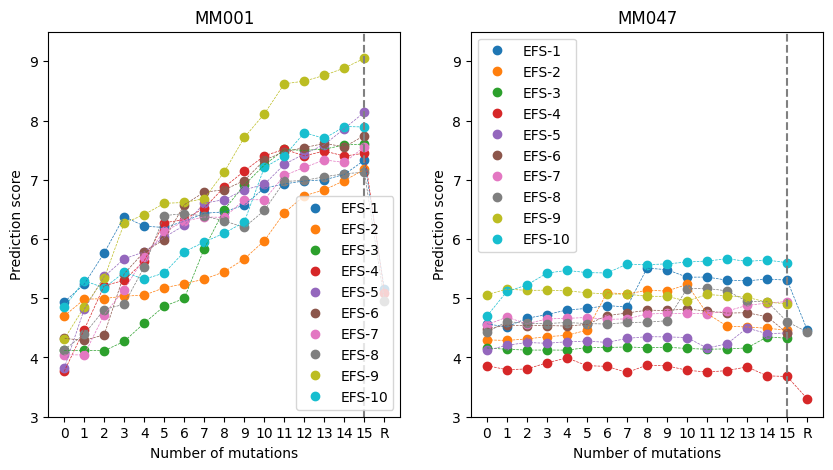

In [6]:
fig = plt.figure(figsize=(10,5))
for i, MM_line in enumerate(models):
    ax = fig.add_subplot(1,2,i+1)
    for k,id_ in enumerate([15,17,19,22,27,45,49,60,68,72]):
        _ = plt.plot(predictions_efs[MM_line]['scalar'][id_],label="EFS-"+str(k+1),linestyle="",marker="o",color="C"+str(k))
    plt.legend()
    for k,id_ in enumerate([15,17,19,22,27,45,49,60,68,72]):
        _ = plt.plot(predictions_efs[MM_line]['scalar'][id_],label="EFS-"+str(k+1),linestyle="--",linewidth=0.5,color="C"+str(k))
    _ = plt.xticks(range(17),list(range(16))+["R"])
    plt.axvline(x=15,linestyle="--",color="gray")
    plt.xlabel("Number of mutations")
    plt.ylabel("Prediction score")
    plt.title(MM_line)
    plt.ylim(3,9.5)
plt.savefig("figures/chrombpnet/EFS_SelectedSeqs_Prediction_MM001_MM047_scalar.pdf",transparent=True)

### Plotting track prediction scores of synthetic enhancer at different mutational and repressed steps

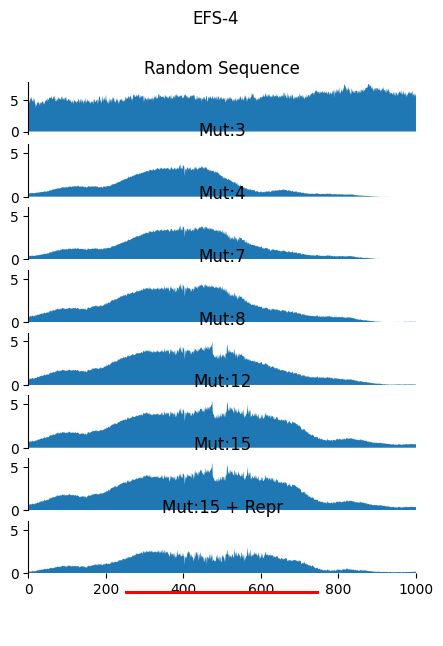

In [7]:
id_=22
name_="EFS-4"
MM_line = "MM001"
muts = [3,4,7,8,12,15,16]
n_tracks = len(muts) + 2

fig = plt.figure(figsize=(5,0.8*n_tracks))
fig.suptitle(name_)

ax  = fig.add_subplot(n_tracks,1,1)
values = predictions_efs["MM001"]['track'][id_][0]
ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
ax.set_title("Random Sequence")
ax.set_xticks([])
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)


for i, n_mut in enumerate(muts):
    
    ax  = fig.add_subplot(n_tracks,1,i+2)
    values = predictions_efs["MM001"]['track'][id_][n_mut] - predictions_efs["MM001"]['track'][id_][0]
    ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
    ax.set_ylim(0,6)
    if n_mut==16:
        ax.set_title("Mut:15 + Repr")
    else:
        ax.set_title("Mut:"+str(n_mut))
    ax.margins(x=0)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    
    if i!=len(muts)-1:
        ax.set_xticks([])
        
ax  = fig.add_subplot(n_tracks,1,n_tracks)
rect = mpatches.Rectangle((250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([0,1000])
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("figures/chrombpnet/ChromBPNet_"+name_+"_steps_prediction_track_"+MM_line+".pdf",transparent=True)


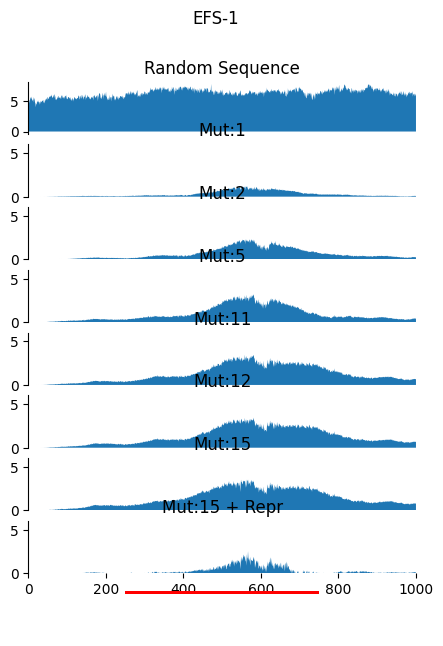

In [8]:
id_=15
name_="EFS-1"
MM_line = "MM001"
muts = [1,2,5,11,12,15,16]
n_tracks = len(muts) + 2

fig = plt.figure(figsize=(5,0.8*n_tracks))
fig.suptitle(name_)

ax  = fig.add_subplot(n_tracks,1,1)
values = predictions_efs["MM001"]['track'][id_][0]
ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
ax.set_title("Random Sequence")
ax.set_xticks([])
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)


for i, n_mut in enumerate(muts):
    
    ax  = fig.add_subplot(n_tracks,1,i+2)
    values = predictions_efs["MM001"]['track'][id_][n_mut] - predictions_efs["MM001"]['track'][id_][0]
    ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
    ax.set_ylim(0,6)
    if n_mut==16:
        ax.set_title("Mut:15 + Repr")
    else:
        ax.set_title("Mut:"+str(n_mut))
    ax.margins(x=0)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    
    if i!=len(muts)-1:
        ax.set_xticks([])
        
ax  = fig.add_subplot(n_tracks,1,n_tracks)
rect = mpatches.Rectangle((250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([0,1000])
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("figures/chrombpnet/ChromBPNet_"+name_+"_steps_prediction_track_"+MM_line+".pdf",transparent=True)


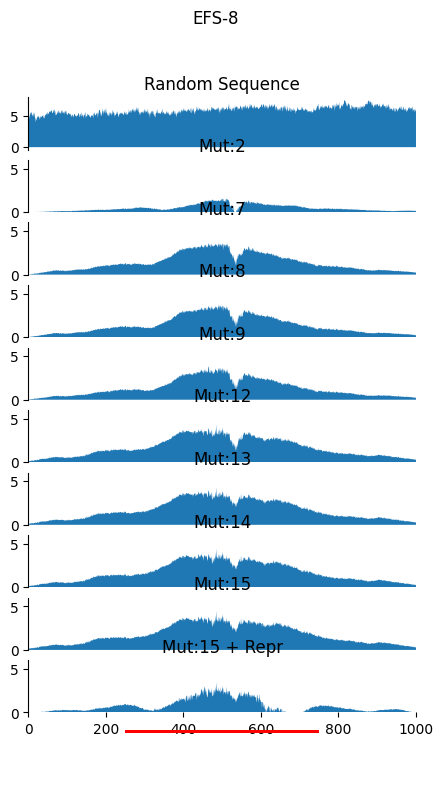

In [9]:
id_=60
name_="EFS-8"
MM_line = "MM001"
muts = [2,7,8,9,12,13,14,15,16]
n_tracks = len(muts) + 2

fig = plt.figure(figsize=(5,0.8*n_tracks))
fig.suptitle(name_)

ax  = fig.add_subplot(n_tracks,1,1)
values = predictions_efs["MM001"]['track'][id_][0]
ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
ax.set_title("Random Sequence")
ax.set_xticks([])
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)


for i, n_mut in enumerate(muts):
    
    ax  = fig.add_subplot(n_tracks,1,i+2)
    values = predictions_efs["MM001"]['track'][id_][n_mut] - predictions_efs["MM001"]['track'][id_][0]
    ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
    ax.set_ylim(0,6)
    if n_mut==16:
        ax.set_title("Mut:15 + Repr")
    else:
        ax.set_title("Mut:"+str(n_mut))
    ax.margins(x=0)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    
    if i!=len(muts)-1:
        ax.set_xticks([])
        
ax  = fig.add_subplot(n_tracks,1,n_tracks)
rect = mpatches.Rectangle((250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([0,1000])
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("figures/chrombpnet/ChromBPNet_"+name_+"_steps_prediction_track_"+MM_line+".pdf",transparent=True)


### Loading the IRF4 enhancer sequence with different motif modifications and calculating prediction scores

In [10]:
irf4_onehot = {}
irf4_onehot["wild-type"] = utils.one_hot_encode_along_row_axis("GCTGCCATTGGTGTGGATTTTAAGTTGGGGAGGGTCGGGCGTGTCCGCCTGTTGGAATATGCTTCTCAGGTCTTCTGGGAAACAGATGTTTTGTGGAAGTGGAAGATTTTGGAAGTAGTGCCTTATCATGTGAAACCACAGGGCAGCTGATCTCTTCAGGCTTTCTTGATGTGAATGACAGCTTTGTTTCATCCACTTTGGTGGGTAAAAGAAGGCAAATTCCCCTGTGGTACTTTTGGTGCCAGGTTTAGCCATATGACGAAGCTTTACATAAAACAGTACAAGTATCTCCATTGTCCTTTATGATCCTCCATGAGTGTTTTCACTTAGTCTGATGAAGGGTTCACTCCAGTCTTTTCGGATGATAAAATGCTTCGGCTGTCAGTCTAATAAGGGATTCCCTGAGGAGTTTGGAGGCTGTAAGAGCACCCCCCGTCTCAATGCCAGTGCTTCTTATCTCAGCCTCTCCTGCACTCCTTTACCCCCGTCTCGATGCCAGT")
irf4_onehot["more_ZEB2"] = utils.one_hot_encode_along_row_axis("GCTGCCATTGGTGTGGATTTTAAGTTGGGGAGGGTCGGGCGTGTCCGCCTGTTGGAATATGCTTCTCAGGTCTTCTGGGAAACAGGTGTTTTGTGGAAGTGGAAGATTTTGGAAGTAGTACCTTATCATGTGAAACCACAGGGCAGCTGATCTCTTCAGGCTTTCTTGATGTGAATGACAGCTTTGTTTCATCCACCTTGGTAGGTAAAAGAAGGTAAATTCCCCTGTGGTACTTTTGGTGCCAGGTTTAGCCATATGACGAAGCTTTACCTAAAACAGTACAAGTATCTCCATTGTCCTTTATGATCCTCCATGAGTGTTTTCACCTAGTCTGATGAAGGGTTCACTCCAGTCTTTTCGGATGATAAAATGCTTCGGCTGTCAGTCTAATAAGGGATTCCCTGAGGAGTTTGGAGGCTGTAAGAGCACCCCCCGTCTCAATGCCAGTGCTTCTTATCTCAGCCTCTCCTGCACTCCTTTACCCCCGTCTCGATGCCAGT")
irf4_onehot["no_MITF"]   = utils.one_hot_encode_along_row_axis("GCTGCCATTGGTGTGGATTTTAAGTTGGGGAGGGTCGGGCGTGTCCGCCTGTTGGAATATGCTTCTCAGGTCTTCTGGGAAACAGATGTTTTGTGGAAGTGGAAGATTTTGGAAGTAGTGCCTTATAATGTAAAACCACAGGGCAGCTGATCTCTTCAGGCTTTCTTGATGTGAATGACAGCTTTGTTTCATCCACTTTGGTGGGTAAAAGAAGGCAAATTCCCCTGTGGTACTTTTGGTGCCAGGTTTAGCAATATAACGAAGCTTTACATAAAACAGTACAAGTATCTCCATTGTCCTTTATGATCCTCCATGAGTGTTTTCACTTAGTCTGATGAAGGGTTCACTCCAGTCTTTTCGGATGATAAAATGCTTCGGCTGTCAGTCTAATAAGGGATTCCCTGAGGAGTTTGGAGGCTGTAAGAGCACCCCCCGTCTCAATGCCAGTGCTTCTTATCTCAGCCTCTCCTGCACTCCTTTACCCCCGTCTCGATGCCAGT")
irf4_onehot["no_SOX10"]  = utils.one_hot_encode_along_row_axis("GCTGCCATTGGTGTGGATTTTAAGTTGGGGAGGGTCGGGCGTGTCCGCCTGTTGGAATATGCTTCTCAGGTCTTCTGGGAAACAGATGTTTTGTGGAAGTGGAAGATTTTGGAAGTAGTGCCTTATCATGTGAAACCACAGGGCAGCTGATCTCTTCAGGCTTTCTTGATGTGGATGACAGCTTGTGTTCATCCACTTTGGTGGGTAAAAGAAGGCAAATTCCCCTGTGGTACTTTTGGTGCCAGGTTTAGCCATATGACGAAGCTTTACATAAAACAGTACAGGTATCTCCATGTGCCTTTATGATCCTCCATGAGTGTTTTCACTTAGTCTGATGAAGGGTTCACTCCAGTCTTTTCGGATGATAAAATGCTTCGGCTGTCAGTCTAATAAGGGATTCCCTGAGGAGTTTGGAGGCTGTAAGAGCACCCCCCGTCTCAATGCCAGTGCTTCTTATCTCAGCCTCTCCTGCACTCCTTTACCCCCGTCTCGATGCCAGT")
irf4_onehot["no_ZEB2"]   = utils.one_hot_encode_along_row_axis("GCTGCCATTGGTGTGGATTTTAAGTTGGGGAGGGTCGGGCGTGTCCGCCTGTTGGAATATGCTTCTCGGATCTTCTGGGAAACAGATGTTTTGTGGAAGTGGAAGATTTTGGAAGTAGTGCCTTATCATGTGAAACCACAGGGCAGCTGATCTCTTCAGGCTTTCTTGATGTGAATGACAGCTTTGTTTCATCCACTTTGGTGGGTAAAAGAAGGCAAATTCCCCTGTGGTACTTTTGGTGCCGGATTTAGCCATATGACGAAGCTTTACATAAAACAGTACAAGTATCTCCATTGTCCTTTATGATCCTCCATGAGTGTTTTCACTTAGTCTGATGAAGGGTTCACTCCAGTCTTTTCGGATGATAAAATGCTTCGGCTGTCAGTCTAATAAGGGATTCCCTGAGGAGTTTGGAGGCTGTAAGAGCACCCCCCGTCTCAATGCCAGTGCTTCTTATCTCAGCCTCTCCTGCACTCCTTTACCCCCGTCTCGATGCCAGT")

predictions_irf4 = {}
predictions_irf4['track'] = {}
predictions_irf4['scalar'] = {}

for seq_ in irf4_onehot:
    pred = models[MM_line].predict(np.hstack((upstream_seq,irf4_onehot[seq_],downstream_seq)))
    predictions_irf4['track'][seq_]=pred[0][0]
    predictions_irf4['scalar'][seq_]=pred[1][0][0]

### Plotting scalar prediction scores for the IRF4 enhancer sequence with different motif modifications

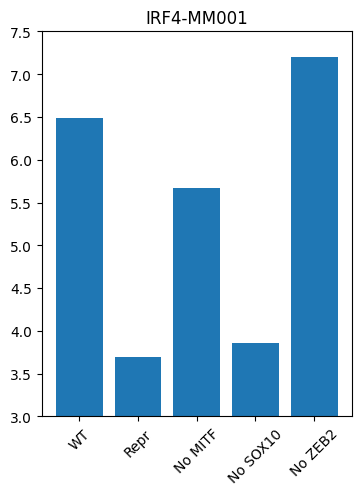

In [11]:
fig = plt.figure(figsize=(4,5))
plt.title("IRF4-MM001")

for i,key in enumerate(predictions_irf4['scalar']):
    plt.bar(i,np.array(predictions_irf4['scalar'][key]),label=key,color="C0")
plt.ylim(3,7.5)
plt.xticks(range(5),['WT',"Repr","No MITF","No SOX10","No ZEB2"],rotation=45)
plt.savefig("figures/chrombpnet/ChromBPNet_IRF4_mutations_prediction_scalar.pdf",transparent=True)

### Plotting track prediction scores for the IRF4 enhancer sequence with different motif modifications

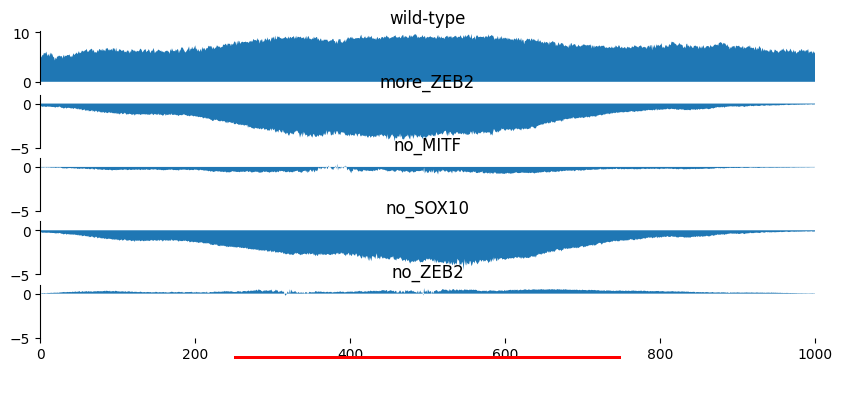

In [12]:
start = 0
end = 1000

n_tracks = 6
fig = plt.figure(figsize=(10,0.8*n_tracks))
#plt.title("IRF4-MM001")
ax  = fig.add_subplot(n_tracks,1,1)
values = predictions_irf4['track']["wild-type"]
ax.fill_between(np.linspace(0, len(values), num=len(values)),0,values)
ax.set_xticks([])
ax.set_title("wild-type")
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)

for i,key in enumerate(['more_ZEB2', 'no_MITF', 'no_SOX10', 'no_ZEB2']):
    ax = fig.add_subplot(n_tracks,1,i+2)
    values = predictions_irf4['track'][key] - predictions_irf4['track']["wild-type"]
    ax.fill_between(np.linspace(start, end, num=len(values)),0,values) 
    ax.set_ylim(-5,1)
    ax.set_title(key)
    ax.margins(x=0)
    if i!=3:
        ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    
ax  = fig.add_subplot(n_tracks,1,n_tracks)
rect = mpatches.Rectangle((250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([0,1000])
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("figures/chrombpnet/ChromBPNet_IRF4_mutations_prediction_track.pdf",transparent=True)

### Calculating in silico saturation mutagenesis scores on wild-type IRF4 enhancer by using the ChromBPNet model

In [13]:
from tqdm import tqdm

modified_sequence_one_hot = np.hstack((upstream_seq,irf4_onehot["wild-type"],downstream_seq))

irf4_ism = utils.create_saturation_mutagenesis_x(irf4_onehot["wild-type"])
irf4_ism['Prediction'] = []

for i in tqdm(range(500*3)):
    modified_sequence_one_hot = np.copy(np.hstack((upstream_seq,irf4_onehot["wild-type"],downstream_seq)))
    modified_sequence_one_hot[:,807:807+500,:] = irf4_ism['X'][i]
    pred = models["MM001"].predict(modified_sequence_one_hot)
    irf4_ism['Prediction'].append(pred[1][0][0])

modified_sequence_one_hot = np.copy(np.hstack((upstream_seq,irf4_onehot["wild-type"],downstream_seq)))
irf4_original_pred = models["MM001"].predict(modified_sequence_one_hot)[1][0][0]

100%|██████████| 1500/1500 [00:57<00:00, 26.07it/s]


### Function that plots saturation mutagenesis values

In [ ]:
def plot_mutagenesis_givenax_fast(mut_scores,ids_,original_prediction, fig, ntrack, track_no, title='Enformer ISM'):
    seq_shape = (500,4)
    arr_a = np.zeros(seq_shape[0])
    arr_c = np.zeros(seq_shape[0])
    arr_g = np.zeros(seq_shape[0])
    arr_t = np.zeros(seq_shape[0])
    mut_preds = mut_scores
    delta_pred = original_prediction - mut_preds
    for i,mut in enumerate(ids_):
        if mut.endswith("A"):
            arr_a[int(mut.split("_")[0])]=delta_pred[i]
        if mut.endswith("C"):
            arr_c[int(mut.split("_")[0])]=delta_pred[i]
        if mut.endswith("G"):
            arr_g[int(mut.split("_")[0])]=delta_pred[i]
        if mut.endswith("T"):
            arr_t[int(mut.split("_")[0])]=delta_pred[i]

    arr_a[arr_a == 0] = None
    arr_c[arr_c == 0] = None
    arr_g[arr_g == 0] = None
    arr_t[arr_t == 0] = None
    
    ax = fig.add_subplot(ntrack, 1, track_no)
    ax.set_ylabel('In silico\nMutagenesis\n')
    ax.set_title(title)
    ax.scatter(range(seq_shape[0]), -1*arr_a, label='A', color='green')
    ax.scatter(range(seq_shape[0]), -1*arr_c, label='C', color='blue')
    ax.scatter(range(seq_shape[0]), -1*arr_g, label='G', color='orange')
    ax.scatter(range(seq_shape[0]), -1*arr_t, label='T', color='red')
    ax.legend()
    ax.axhline(y=0, linestyle='--', color='gray')
    ax.set_xlim((0, seq_shape[0]))
    _ = ax.set_xticks(np.arange(0, seq_shape[0]+1, 10))

    return ax

### Plotting saturation mutagenesis values of IRF4 enhancer calculated by using ChromBPNet MM001 model.

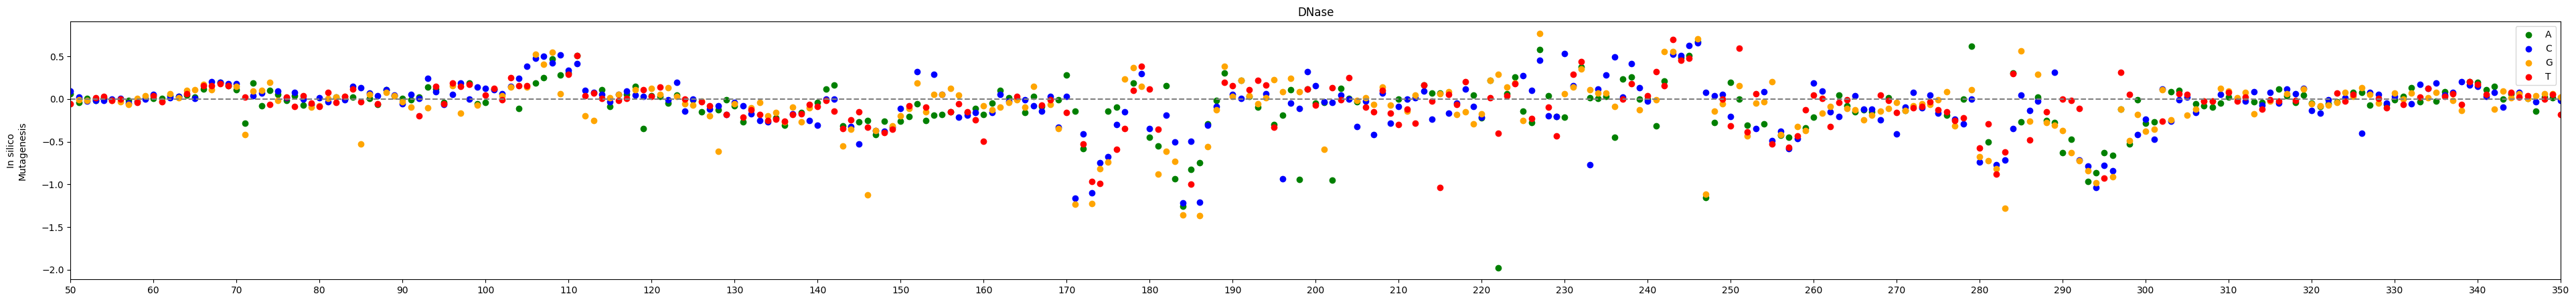

In [15]:
ntrack = 1
fig = plt.figure(figsize=(48,ntrack*5))
st = 50
end = 350
ax1 = plot_mutagenesis_givenax_fast(irf4_ism['Prediction'], irf4_ism["ids"], irf4_original_pred, fig, ntrack, 1, title="DNase")

ax1.set_xlim([st,end])
plt.savefig("figures/chrombpnet/IRF4_ISM_MM001_scalar.pdf",transparent=True)